# Supervised Learning: SVC

In [3]:
# Imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn.metrics as metrics
from sklearn.metrics import recall_score, make_scorer, roc_auc_score

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split, KFold, RandomizedSearchCV, GridSearchCV

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# import os

# BASE_FOLDER="/content/drive/MyDrive/Master-VIU/09MIAR_TFM/Tumor-Educated_Platelets/data/"
# PROYECTO="IntVeld2022"
# PROYECT_FOLDER = os.path.join(BASE_FOLDER,PROYECTO)

PROYECT_FOLDER = ""

## Read File


In [4]:
# Read dataFrame
file='DataPatients_train.csv'
df_train = pd.read_csv(os.path.join(PROYECT_FOLDER,file), sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})

file='DataPatients_test.csv'
df_test = pd.read_csv(os.path.join(PROYECT_FOLDER,file), sep=';',index_col=0, na_values='n.a.', dtype={'Stage': 'object', 'Age': 'float64'})

In [5]:
df_train.head(3)

,ENSG00000000419,ENSG00000000938,ENSG00000002330,ENSG00000002549,ENSG00000002586,ENSG00000003056,ENSG00000003436,ENSG00000003756,ENSG00000004059,ENSG00000004142,...,Sample ID,Stage,Sex,Age,Sample-supplying institution,Training series,Evaluation series,Validation series,Class_group,Patient_group
2840-UMCU-nSTEMI-2-0682-TR2004,16.326226,120.048709,52.477851,44.059578,3730.990583,35.378754,53.324363,47.100353,410.170309,11.302610,...,UMCU-nSTEMI-2-0682-TR2004,NaN,M,45.0,Institute 10,0,0,1,nonMalignant,nSTEMI
660-Vumc-LGG-VU683-TR2156,0.000000,21.112210,91.203733,1.531464,5104.112535,9.837825,95.273289,19.135619,307.264798,26.191118,...,Vumc-LGG-VU683-TR2156,NaN,F,31.0,Institute 13,0,0,1,Malignant,Glioma
331-NKI-107-005472-HD-TR3284,96.467707,838.720636,7.973457,240.998016,1356.525244,223.080323,62.469277,148.704478,335.781586,62.968130,...,NKI-107-005472-HD-TR3284,NaN,F,64.0,Institute 5,1,0,0,nonMalignant,Asymptomatic controls


## Remove some columns, numeric labels and Split X and Y

In [6]:
# Split X and Y
# Choose which label to use for ground truth (in this case class)

columns = df_train.columns    # 'ENSGxxxx' ... 'Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution',
#                         'Training series', 'Evaluation series', 'Validation series',
#                         'Class_group', 'Patient_group'],
X_train = df_train[columns[0:-10]]
y_train_c = df_train[columns[-2]]

X_test = df_test[columns[0:-10]]
y_test_c= df_test[columns[-2]]

unique, counts = np.unique(y_train_c, return_counts=True)
print("Train")
print(unique)
print(counts)
print("Test")
unique, counts = np.unique(y_test_c, return_counts=True)
print(unique)
print(counts)

y_train = y_train_c.apply(lambda x: 1 if x == 'Malignant' else 0)
y_test = y_test_c.apply(lambda x: 1 if x == 'Malignant' else 0)

Train
['Malignant' 'nonMalignant']
[1313  566]
Test
['Malignant' 'nonMalignant']
[313 157]


In [7]:
# y_train_c.head(4)

In [8]:
# y_test_c.head(4)

Decissions taken:
* Variables: only genes (for the moment, not use sex, age, stage etc.)
* Ground truth: class_patient 
* Train with all nonMalignant (assymptomatics and symptomatics)

## SVC (Support vector machine algorithm), 2881 genes, all patients

### Get the best estimator from the grid search (ran using only training data)

#### Maximizing accuracy

In [ ]:
params = {
    'C': [0.1, 1, 10, 100, 1000], # It controls the trade off between smooth decision boundary and classifying the training points correctly
    'kernel': ['linear', 'rbf', 'poly'],  # ‘rbf’ and ‘poly’ uses a non linear hyper-plane
    'gamma': [0.1, 1, 10, 100], # gamma is for non linear hyperplanes. The higher the gamma value, it tries to exactly fit the training data set
    'random_state': [42]
}

random_search_acc = RandomizedSearchCV(estimator = SVC(), param_distributions = params, random_state = 42, scoring = 'accuracy', n_jobs=-1, n_iter = 10, verbose=3)
random_search_acc.fit(X_train, y_train)

# Extract best parameters and best metric
print("Best params: ", random_search_acc.best_params_)
print("Best score: ", random_search_acc.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params:  {'random_state': 42, 'kernel': 'poly', 'gamma': 1, 'C': 0.1}
Best score:  0.7865914893617021


In [ ]:
results = pd.DataFrame(random_search_acc.cv_results_)
columns_r = list(results.columns)
# print(columns_r)
columns_r = columns_r[:5] + columns_r[8:-3] + columns_r[-2:-2]
results.drop(columns=columns_r, inplace = True)
results

,param_kernel,param_gamma,param_C,mean_test_score,std_test_score,rank_test_score
0,linear,0.1,0.1,0.782325,0.014112,2
1,poly,1,0.1,0.786591,0.012125,1
2,linear,0.1,100,0.782325,0.014112,2
3,linear,100,100,0.782325,0.014112,2
4,rbf,0.1,1,0.698776,0.001031,10
5,linear,10,1000,0.782325,0.014112,2
6,linear,100,10,0.782325,0.014112,2
7,linear,0.1,1000,0.782325,0.014112,2
8,linear,0.1,1,0.782325,0.014112,2
9,linear,100,1000,0.782325,0.014112,2


In [ ]:
params = {
    'C': [0.1, 1, 5], # It controls the trade off between smooth decision boundary and classifying the training points correctly
    'kernel': ['poly'],  # ‘rbf’ and ‘poly’ uses a non linear hyper-plane
    'gamma': [0.1, 1, 10], # gamma is for non linear hyperplanes. The higher the gamma value, it tries to exactly fit the training data set
    'random_state': [42]
}

random_search_acc = RandomizedSearchCV(estimator = SVC(), param_distributions = params, random_state = 42, scoring = 'accuracy', n_jobs=-1, n_iter = 4, verbose=3)
random_search_acc.fit(X_train, y_train)

# Extract best parameters and best metric
print("Best params: ", random_search_acc.best_params_)
print("Best score: ", random_search_acc.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best params:  {'random_state': 42, 'kernel': 'poly', 'gamma': 1, 'C': 5}
Best score:  0.7865914893617021


In [ ]:
results = pd.DataFrame(random_search_acc.cv_results_)
columns_r = list(results.columns)
# print(columns_r)
columns_r = columns_r[:5] + columns_r[8:-3] + columns_r[-2:-2]
results.drop(columns=columns_r, inplace = True)
results

,param_kernel,param_gamma,param_C,mean_test_score,std_test_score,rank_test_score
0,poly,1,5,0.786591,0.012125,1
1,poly,1,0.1,0.786591,0.012125,1
2,poly,10,1,0.786591,0.012125,1
3,poly,0.1,0.1,0.786591,0.012125,1


#### Maximizing specificity

In [ ]:
params = {
    'C': [0.1, 1, 10, 100, 1000], # It controls the trade off between smooth decision boundary and classifying the training points correctly
    'kernel': ['linear', 'rbf', 'poly'],  # ‘rbf’ and ‘poly’ uses a non linear hyper-plane
    'gamma': [0.1, 1, 10, 100], # gamma is for non linear hyperplanes. The higher the gamma value, it tries to exactly fit the training data set
    'random_state': [42]
}

random_search_spe = RandomizedSearchCV(estimator = SVC(), param_distributions = params, random_state = 42, scoring = make_scorer(recall_score,pos_label=0), n_jobs=-1, n_iter = 10, verbose=3)
random_search_spe.fit(X_train, y_train)

# Extract best parameters and best metric
print("Best params: ", random_search_spe.best_params_)
print("Best score: ", random_search_spe.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params:  {'random_state': 42, 'kernel': 'poly', 'gamma': 1, 'C': 0.1}
Best score:  0.6800652072659524


In [ ]:
results = pd.DataFrame(random_search_spe.cv_results_)
columns_r = list(results.columns)
# print(columns_r)
columns_r = columns_r[:5] + columns_r[8:-3] + columns_r[-2:-2]
results.drop(columns=columns_r, inplace = True)
results

,param_kernel,param_gamma,param_C,mean_test_score,std_test_score,rank_test_score
0,linear,0.1,0.1,0.655442,0.046388,2
1,poly,1,0.1,0.680065,0.058058,1
2,linear,0.1,100,0.655442,0.046388,2
3,linear,100,100,0.655442,0.046388,2
4,rbf,0.1,1,0.000000,0.000000,10
5,linear,10,1000,0.655442,0.046388,2
6,linear,100,10,0.655442,0.046388,2
7,linear,0.1,1000,0.655442,0.046388,2
8,linear,0.1,1,0.655442,0.046388,2
9,linear,100,1000,0.655442,0.046388,2


### Train the best estimator with training data and test it in test data


In [ ]:
# Once hyperparameters have been optimized, the final model is trained and tested
# model = random_search_spe.best_estimator_
SVM = SVC(random_state= 42, kernel= 'poly', gamma= 1, C= 0.1, probability=True)
SVM.fit(X_train, y_train)   # entrenamiento completo

y_pred = SVM.predict(X_test)
test_results = SVM.score(X_test, y_test) 
print('Test accuracy: ', np.round(test_results*100,4), '%')

Test accuracy:  80.2128 %


In [ ]:
print("Tabla de métricas:\n", metrics.classification_report(y_test, y_pred))


Tabla de métricas:
               precision    recall  f1-score   support

           0       0.70      0.71      0.70       157
           1       0.85      0.85      0.85       313

    accuracy                           0.80       470
   macro avg       0.78      0.78      0.78       470
weighted avg       0.80      0.80      0.80       470



In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))

[[111  46]
 [ 47 266]]


In [ ]:
auc = roc_auc_score(y_test, SVM.predict_proba(X_test)[:, 1])
print(auc)

0.8378950367310394


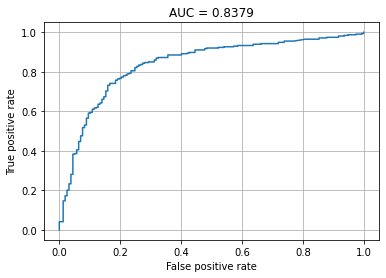

In [ ]:
# Plot ROC curve
y_proba_test = SVM.predict_proba(X_test)
fpr, tpr, th = metrics.roc_curve(y_test, y_proba_test[:,1])

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid()
plt.show()

## SVC: 2881 genes,  removing symptomatics from healthy

Article: Symptomatic controls were not included in the training and evaluation series because of their overrepresented prevalence as opposed to the asymptomatic controls, compared with a real-world setting.

In [ ]:
print(df_train.shape, df_test.shape)

(1879, 2891) (470, 2891)


In [ ]:
# Remove symptomatic nonMalignant cases
df_train_new = df_train.drop(df_train[(df_train['Class_group'] == 'nonMalignant') & (df_train['Patient_group'] != 'Asymptomatic controls')].index)
df_test_new = df_test.drop(df_test[(df_test['Class_group'] == 'nonMalignant') & (df_test['Patient_group'] != 'Asymptomatic controls')].index)

In [ ]:
print(df_train_new.shape, df_test_new.shape)

(1619, 2891) (397, 2891)


In [ ]:
columns = df_train_new.columns    # 'ENSGxxxx' ... 'Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution',
#                         'Training series', 'Evaluation series', 'Validation series',
#                         'Class_group', 'Patient_group'],
X_train = df_train_new[columns[0:-10]]
y_train_c = df_train_new[columns[-2]]

X_test = df_test_new[columns[0:-10]]
y_test_c= df_test_new[columns[-2]]

unique, counts = np.unique(y_train_c, return_counts=True)
print("Train")
print(unique)
print(counts)
print("Test")
unique, counts = np.unique(y_test_c, return_counts=True)
print(unique)
print(counts)
y_train = y_train_c.apply(lambda x: 1 if x == 'Malignant' else 0)
y_test = y_test_c.apply(lambda x: 1 if x == 'Malignant' else 0)

Train
['Malignant' 'nonMalignant']
[1313  306]
Test
['Malignant' 'nonMalignant']
[313  84]


Find best hyperparameters

In [ ]:
params = {
    'C': [0.1, 1, 10, 100, 1000], # It controls the trade off between smooth decision boundary and classifying the training points correctly
    'kernel': ['linear', 'rbf', 'poly'],  # ‘rbf’ and ‘poly’ uses a non linear hyper-plane
    'gamma': [0.1, 1, 10, 100], # gamma is for non linear hyperplanes. The higher the gamma value, it tries to exactly fit the training data set
    'random_state': [42]
}

random_search_spe = RandomizedSearchCV(estimator = SVC(), param_distributions = params, random_state = 42, scoring = make_scorer(recall_score,pos_label=0), n_jobs=-1, n_iter = 10, verbose=3)
random_search_spe.fit(X_train, y_train)

# Extract best parameters and best metric
print("Best params: ", random_search_spe.best_params_)
print("Best score: ", random_search_spe.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best params:  {'random_state': 42, 'kernel': 'linear', 'gamma': 0.1, 'C': 0.1}
Best score:  0.7026969857218404


In [ ]:
results = pd.DataFrame(random_search_spe.cv_results_)
columns_r = list(results.columns)
# print(columns_r)
columns_r = columns_r[:5] + columns_r[8:-3] + columns_r[-2:-2]
results.drop(columns=columns_r, inplace = True)
results

,param_kernel,param_gamma,param_C,mean_test_score,std_test_score,rank_test_score
0,linear,0.1,0.1,0.702697,0.030863,1
1,poly,1,0.1,0.676573,0.036905,9
2,linear,0.1,100,0.702697,0.030863,1
3,linear,100,100,0.702697,0.030863,1
4,rbf,0.1,1,0.000000,0.000000,10
5,linear,10,1000,0.702697,0.030863,1
6,linear,100,10,0.702697,0.030863,1
7,linear,0.1,1000,0.702697,0.030863,1
8,linear,0.1,1,0.702697,0.030863,1
9,linear,100,1000,0.702697,0.030863,1


Train model and test it

In [ ]:
# Once hyperparameters have been optimized, the final model is trained and tested
# model = random_search_spe.best_estimator_
SVM = SVC(random_state= 42, kernel= 'linear', gamma= 0.1, C= 0.1, probability=True)
SVM.fit(X_train, y_train)   # entrenamiento completo

y_pred = SVM.predict(X_test)
test_results = SVM.score(X_test, y_test) 
print('Test accuracy: ', np.round(test_results*100,4), '%')

Test accuracy:  87.9093 %


In [ ]:
print("Tabla de métricas:\n", metrics.classification_report(y_test, y_pred))


Tabla de métricas:
               precision    recall  f1-score   support

           0       0.72      0.70      0.71        84
           1       0.92      0.93      0.92       313

    accuracy                           0.88       397
   macro avg       0.82      0.81      0.82       397
weighted avg       0.88      0.88      0.88       397



In [ ]:
print(metrics.confusion_matrix(y_test, y_pred))

[[ 59  25]
 [ 23 290]]


In [ ]:
auc = roc_auc_score(y_test, SVM.predict_proba(X_test)[:, 1])
print(auc)

0.9187205233531112


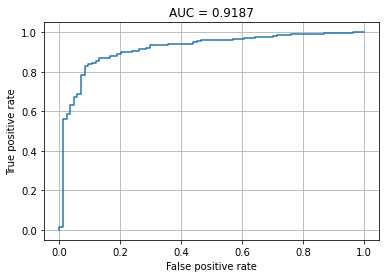

In [ ]:
# Plot ROC curve
y_proba_test = SVM.predict_proba(X_test)
fpr, tpr, th = metrics.roc_curve(y_test, y_proba_test[:,1])

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid()
plt.show()

## SVC, 2881 genes, all patients -> Handling imbalanced class

In [9]:
# Split X and Y
# Choose which label to use for ground truth (in this case class)

columns = df_train.columns    # 'ENSGxxxx' ... 'Sample ID', 'Stage', 'Sex', 'Age', 'Sample-supplying institution',
#                         'Training series', 'Evaluation series', 'Validation series',
#                         'Class_group', 'Patient_group'],
X_train = df_train[columns[0:-10]]
y_train_c = df_train[columns[-2]]

X_test = df_test[columns[0:-10]]
y_test_c= df_test[columns[-2]]

unique, counts = np.unique(y_train_c, return_counts=True)
print("Train")
print(unique)
print(counts)
print("Test")
unique, counts = np.unique(y_test_c, return_counts=True)
print(unique)
print(counts)

y_train = y_train_c.apply(lambda x: 1 if x == 'Malignant' else 0)
y_test = y_test_c.apply(lambda x: 1 if x == 'Malignant' else 0)

Train
['Malignant' 'nonMalignant']
[1313  566]
Test
['Malignant' 'nonMalignant']
[313 157]


In [ ]:
# import multiprocessing
# n_cpus = multiprocessing.cpu_count()
# print(n_cpus)

In [10]:
# https://elitedatascience.com/imbalanced-classes

params = {
    'C': [0.1, 1, 10], # It controls the trade off between smooth decision boundary and classifying the training points correctly
    'kernel': ['linear', 'rbf', 'poly'],  # ‘rbf’ and ‘poly’ uses a non linear hyper-plane
    'gamma': [0.1, 1], # gamma is for non linear hyperplanes. The higher the gamma value, it tries to exactly fit the training data set
    'random_state': [42],
    'class_weight': ['balanced']
}

random_search_spe = RandomizedSearchCV(estimator = SVC(), param_distributions = params, random_state = 42, scoring = make_scorer(recall_score,pos_label=0), n_iter = 4, verbose=2)
random_search_spe.fit(X_train, y_train)

# Extract best parameters and best metric
print("Best params: ", random_search_spe.best_params_)
print("Best score: ", random_search_spe.best_score_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=linear, random_state=42; total time=   9.0s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=linear, random_state=42; total time=   9.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=linear, random_state=42; total time=   9.3s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=linear, random_state=42; total time=   9.6s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=linear, random_state=42; total time=  14.3s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf, random_state=42; total time=   6.3s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf, random_state=42; total time=   4.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf, random_state=42; total time=   4.5s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf, random_state=42; total time=   5.5s
[CV] END C=0.1, class_weight=balanced, gamm

In [11]:
results = pd.DataFrame(random_search_spe.cv_results_)
columns_r = list(results.columns)
# print(columns_r)
columns_r = columns_r[:5] + columns_r[8:-3] + columns_r[-2:-2]
results.drop(columns=columns_r, inplace = True)
results

,param_kernel,param_gamma,param_class_weight,mean_test_score,std_test_score,rank_test_score
0,linear,0.1,balanced,0.655442,0.046388,3
1,rbf,0.1,balanced,0.200000,0.400000,4
2,poly,0.1,balanced,0.680065,0.058058,1
3,poly,1,balanced,0.680065,0.058058,1


Test accuracy:  80.2128 %
Tabla de métricas:
               precision    recall  f1-score   support

           0       0.70      0.71      0.70       157
           1       0.85      0.85      0.85       313

    accuracy                           0.80       470
   macro avg       0.78      0.78      0.78       470
weighted avg       0.80      0.80      0.80       470

[[111  46]
 [ 47 266]]
0.8378746871248042


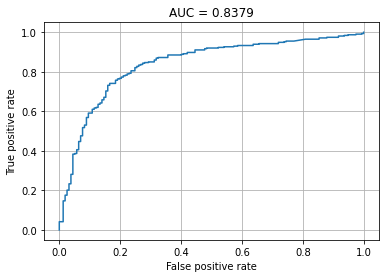

In [13]:
# Once hyperparameters have been optimized, the final model is trained and tested
model = random_search_spe.best_estimator_
model.set_params(probability=True)

model.fit(X_train, y_train)   # entrenamiento completo

y_pred = model.predict(X_test)
test_results = model.score(X_test, y_test) 
print('Test accuracy: ', np.round(test_results*100,4), '%')

print("Tabla de métricas:\n", metrics.classification_report(y_test, y_pred))

print(metrics.confusion_matrix(y_test, y_pred))

auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print(auc)

# Plot ROC curve
y_proba_test = model.predict_proba(X_test)
fpr, tpr, th = metrics.roc_curve(y_test, y_proba_test[:,1])

plt.plot(fpr, tpr)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC = ' + str(np.round(auc,4)))
plt.grid()
plt.show()